## Autora: Shirley Claudette Martínez Cerrato

In [2]:
import sys
!{sys.executable} -m pip install pycm
!{sys.executable} -m pip install imblearn
from hdbcli import dbapi
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
sns.set(style="ticks")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from pycm import ConfusionMatrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Productos Disponibles

In [3]:
productos_bancarios = ('1. CUENTA_CHEQUES', 
'2. CUENTA_AHORROS',
'3. DEPOSITOS_A_PLAZO',
'4. BONOS_DE_CAJA',
'5. PRESTAMOS_CONSUMO',
'6. PRESTAMOS_VIVIENDA',
'7. ADELANTO_PAGO_PLUS',
'8. EXTRAFINANCIAMIENTO',
'9. TC_VISA', 
'10. TC_CASHBACK', 
'11. TC_OLIMPIA',
'12. TC_HMC',
'13. TC_LADY_LEE',
'14. TC_PUMA',
'15. TC_ANTORCHA',
'16. TC_CELEBRA')

In [4]:
print(productos_bancarios)

('1. CUENTA_CHEQUES', '2. CUENTA_AHORROS', '3. DEPOSITOS_A_PLAZO', '4. BONOS_DE_CAJA', '5. PRESTAMOS_CONSUMO', '6. PRESTAMOS_VIVIENDA', '7. ADELANTO_PAGO_PLUS', '8. EXTRAFINANCIAMIENTO', '9. TC_VISA', '10. TC_CASHBACK', '11. TC_OLIMPIA', '12. TC_HMC', '13. TC_LADY_LEE', '14. TC_PUMA', '15. TC_ANTORCHA', '16. TC_CELEBRA')


#### Creamos la conexión a la base de datos

In [5]:
#Cambiar las credenciales user y password
try:
    conn = dbapi.connect(
        address="000.000.00.000", 
        port=0, 
        user="user", 
        password="********"
    )
except:
    print('Error de Conexión')

# Predicción de abandono para Cuenta de Cheques

**Las consultas mostradas a continuación han sido reemplazadas por consultas donde se han cambiado el nombre de las variables y se han anonimizado algunos valores con el fin de protejer la seguridad e integridad del data Warehouse**

In [6]:
cursor = conn.cursor()
sql_command = """SELECT A.CODIGO_DE_CLIENTE, B.CAMPO_GENERO, B.CAMPO_ESTADO_CIVIL, B.CAMPO_NIVEL_EDUCATIVO, B.CAMPO_OCUPACION, 
B.CAMPO_GENERACION, B.CAMPO_REGION, B.CREDITOS_DE_CLIENTE, B.DEBITOS_DE_CLIENTE, B.TRANSACCIONES_PROMEDIO_CLIENTE, A.ESTADO_PRODUCTO
FROM (
SELECT A.CODIGO_DE_CLIENTE, TO_CHAR(A.NUMERO_DE_CUENTA_DEL_PRODUCTO) AS CUENTA,
(CASE WHEN B.CAMPO_ESTADO_DEL_PRODUCTO IS NULL THEN 'Abandono' 
WHEN B.CAMPO_ESTADO_DEL_PRODUCTO NOT LIKE 'ACTIVO' THEN 'Abandono' ELSE 'Vigente' END) AS ESTADO_PRODUCTO
FROM 
(SELECT * FROM ESQUEMA.TABLA_PRODUCTOS_DE_DEPOSITO WHERE PERIODO_DE_ANALISIS BETWEEN TO_DATE('20200301', 'YYYYMMDD') 
AND ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 12) AND FECHA_ADQUISICION_PRODUCTO = PERIODO_DE_ANALISIS AND LEFT(CODIGO_DEL_PRODUCTO, 2) LIKE 'CODIGO PRODUCTO') AS A
LEFT JOIN
(SELECT * FROM ESQUEMA.TABLA_PRODUCTOS_DE_DEPOSITO WHERE PERIODO_DE_ANALISIS BETWEEN ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 6) 
AND ADD_MONTHS(ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 12), 6)) AS B
ON A.NUMERO_DE_CUENTA_DEL_PRODUCTO = B.NUMERO_DE_CUENTA_DEL_PRODUCTO AND A.FECHA_ADQUISICION_PRODUCTO = ADD_MONTHS(B.PERIODO_DE_ANALISIS, -6)
) AS A
INNER JOIN
(SELECT A.CODIGO_DE_CLIENTE,
A.CAMPO_GENERO, 
(CASE WHEN A.CAMPO_ESTADO_CIVIL IN ('CASADO/A', 'MARRIED', 'VERHEIRATET') THEN 'CASADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('DIVORCED', 'DIVORCIADO/A', 'GESCHIEDEN') THEN 'DIVORCIADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('GETRENNT LEBEND', 'SEPARATED') THEN 'SEPARADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('LEDIG', 'SINGLE', 'SOLTERO/A') THEN 'SOLTERO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('VERWITWET', 'VIUDO', 'WIDOWED') THEN 'VIUDO/A'
WHEN A.CAMPO_ESTADO_CIVIL LIKE 'UNIÓN LIBRE' THEN 'UNIÓN LIBRE'
ELSE '' END) AS CAMPO_ESTADO_CIVIL,
(CASE WHEN A.CAMPO_NIVEL_EDUCATIVO IN ('DOCTORADO', 'DOKTOR', 'DR') THEN 'DOCTORADO'
ELSE A.CAMPO_NIVEL_EDUCATIVO END) AS CAMPO_NIVEL_EDUCATIVO,
A.CAMPO_OCUPACION,
B.EDAD_SEGMENTACION AS CAMPO_GENERACION,
B.CAMPO_REGION,
ROUND(IFNULL(T.CREDITO_ULTIMO_ANIO, 0), 2) AS CREDITOS_DE_CLIENTE, 
ROUND(IFNULL(T.DEBITO_ULTIMO_ANIO, 0), 2) AS DEBITOS_DE_CLIENTE,
ROUND(IFNULL(T.NUM_TRANSACCIONES_PROMEDIO_CLIENTE, 0), 2) AS TRANSACCIONES_PROMEDIO_CLIENTE
FROM ESQUEMA.TABLA_CRM_PRINCIPAL AS A
INNER JOIN ESQUEMA.TABLA_CRM_SECUNDARIO AS B ON A.CODIGO_DE_CLIENTE = B.CODIGO_DE_CLIENTE
LEFT JOIN (SELECT TO_CHAR(CODIGO_DE_CLIENTE) AS CODIGO_DE_CLIENTE, TO_DOUBLE(SUM(CASE WHEN TIPO_TRANSACCION='CREDITO' THEN MONTO_TRANSACCION ELSE 0  END )/12) CREDITO_ULTIMO_ANIO,
TO_DOUBLE(ABS(SUM(CASE WHEN TIPO_TRANSACCION='DEBITO' THEN MONTO_TRANSACCION ELSE 0  END ))/12) DEBITO_ULTIMO_ANIO,
TO_DOUBLE(SUM(CASE WHEN CODIGO_CATEGORIA_TRANSACCION IN ('CODIGOS PARA DEBITOS') AND TIPO_TRANSACCION='DEBITO' THEN 1 ELSE 0 END)/12) AS NUM_TRANSACCIONES_PROMEDIO_CLIENTE
FROM ESQUEMA.TABLA_TRANSACCIONAL
WHERE (PERIODO_DE_ANALISIS BETWEEN TO_INT(TO_CHAR(ADD_MONTHS(CURRENT_DATE, -12), 'YYYYMMDD')) AND TO_INT(TO_CHAR(ADD_DAYS(CURRENT_DATE, -1), 'YYYYMMDD')))
AND LEFT(CAMPO_NUMERO_CUENTA_CONTABLE,3) IN ('CODIGOS_PARA_CUENTAS_DE_DEPOSITO') AND NUMERO_CUENTA_DETALLE != 0 GROUP BY CODIGO_DE_CLIENTE) AS T ON A.CODIGO_DE_CLIENTE = T.CODIGO_DE_CLIENTE
WHERE A.CAMPO_ESTADO_CLIENTE LIKE 'ACTIVO' AND A.CAMPO_BANCA_DE_CLIENTE LIKE 'SEGMENTO PERSONAS'
AND A.CAMPO_GENERO NOT LIKE 'N/A'
AND A.CAMPO_ESTADO_CIVIL NOT LIKE ''
AND A.CAMPO_NIVEL_EDUCATIVO NOT LIKE ''
AND A.CAMPO_OCUPACION NOT LIKE 'N/A'
AND B.EDAD_SEGMENTACION NOT LIKE 'O'
AND B.CAMPO_REGION NOT LIKE 'SIN DEFINIR') AS B ON A.CODIGO_DE_CLIENTE = B.CODIGO_DE_CLIENTE;"""

In [7]:
cursor.execute(sql_command)
rows = cursor.fetchall()

In [8]:
new_records = pd.DataFrame(rows, columns=['CODIGO_CLIENTE','GENERO', 'ESTADO_CIVIL', 
                                          'NIVEL_EDUCATIVO', 'OCUPACION', 'GENERACION', 'REGION', 'CREDITOS',
                                          'DEBITOS', 'TRANSACCIONES_PROMEDIO','ESTADO_PRODUCTO'])

In [9]:
new_records

,CODIGO_CLIENTE,GENERO,ESTADO_CIVIL,NIVEL_EDUCATIVO,OCUPACION,GENERACION,REGION,CREDITOS,DEBITOS,TRANSACCIONES_PROMEDIO,ESTADO_PRODUCTO
0,2587167,MASCULINO,SOLTERO/A,SIN ESCOLARIDAD,EMPLEADO PRIVADO,Y,NORTE,0.00,0.00,0.00,Vigente
1,2587167,MASCULINO,SOLTERO/A,SIN ESCOLARIDAD,EMPLEADO PRIVADO,Y,NORTE,0.00,0.00,0.00,Vigente
2,2587175,FEMENINO,SOLTERO/A,SIN ESCOLARIDAD,EMPLEADO PRIVADO,Y,NORTE,0.00,0.00,0.00,Vigente
3,2587175,FEMENINO,SOLTERO/A,SIN ESCOLARIDAD,EMPLEADO PRIVADO,Y,NORTE,0.00,0.00,0.00,Vigente
4,2596627,FEMENINO,SOLTERO/A,PRIMARIA,EMPLEADO PRIVADO,Z,NORTE,0.00,7.50,0.17,Vigente
...,...,...,...,...,...,...,...,...,...,...,...
11297,2529461,MASCULINO,UNIÓN LIBRE,PRIMARIA,EMPLEADO PRIVADO,Y,CENTRO-SUR,6508764.16,6511558.25,1515.75,Vigente
11298,2555897,MASCULINO,CASADO/A,SIN ESCOLARIDAD,COMERCIANTE INDIVIDU,Y,CENTRO-SUR,28458.94,28464.83,3.33,Vigente
11299,2348579,MASCULINO,UNIÓN LIBRE,PRIMARIA,EMPLEADO PRIVADO,X,CENTRO-SUR,30924.01,30887.12,3.83,Vigente
11300,2229786,MASCULINO,SOLTERO/A,SECUNDARIA,EMPLEADO PRIVADO,Z,NORTE,28536.32,28527.39,11.58,Vigente


### Empezamos a explorar el dataset para conocer los aspectos generales del conjunto de datos

In [10]:
print(new_records.shape)#Para saber el número de registros (instancias) y columnas (atributos)

(11302, 11)


In [11]:
print(new_records.groupby('ESTADO_PRODUCTO').size())#Para visualizar los valores de la clase de salida y los valores que la conforman

ESTADO_PRODUCTO
Abandono      368
Vigente     10934
dtype: int64


In [12]:
new_records.info()#para visualizar inofrmación de los atributos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11302 entries, 0 to 11301
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CODIGO_CLIENTE          11302 non-null  object 
 1   GENERO                  11302 non-null  object 
 2   ESTADO_CIVIL            11302 non-null  object 
 3   NIVEL_EDUCATIVO         11302 non-null  object 
 4   OCUPACION               11302 non-null  object 
 5   GENERACION              11302 non-null  object 
 6   REGION                  11302 non-null  object 
 7   CREDITOS                11302 non-null  float64
 8   DEBITOS                 11302 non-null  float64
 9   TRANSACCIONES_PROMEDIO  11302 non-null  float64
 10  ESTADO_PRODUCTO         11302 non-null  object 
dtypes: float64(3), object(8)
memory usage: 971.4+ KB


In [13]:
new_records.describe()

,CREDITOS,DEBITOS,TRANSACCIONES_PROMEDIO
count,1.130200e+04,1.130200e+04,11302.000000
mean,1.359841e+05,1.351728e+05,25.944137
std,1.460898e+06,1.459440e+06,210.148677
min,0.000000e+00,0.000000e+00,0.000000
25%,2.210452e+03,2.257230e+03,0.580000
50%,1.061914e+04,1.057268e+04,3.250000
75%,2.221597e+04,2.192833e+04,10.420000
max,1.073074e+08,1.072843e+08,17230.750000


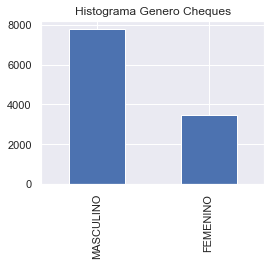

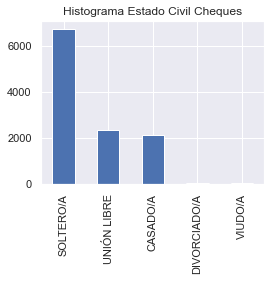

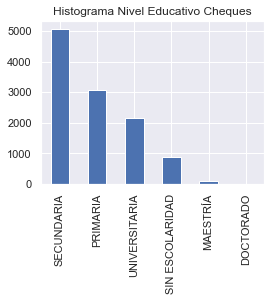

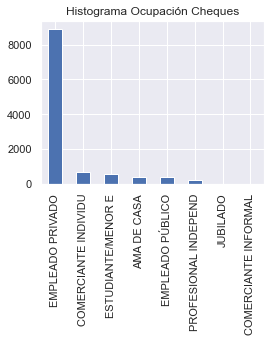

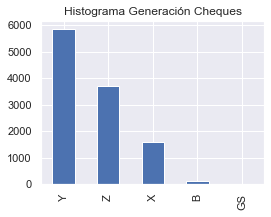

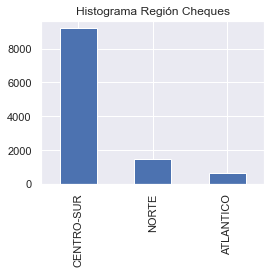

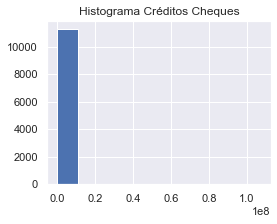

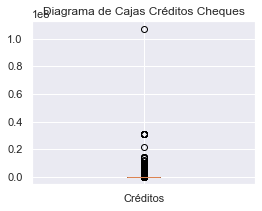

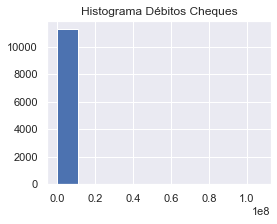

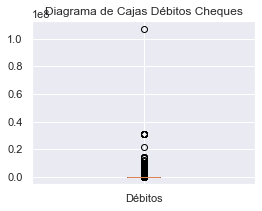

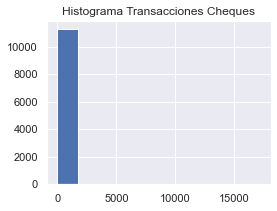

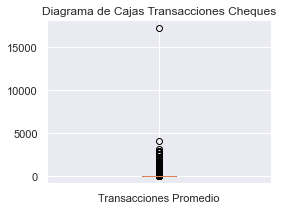

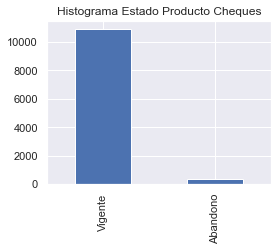

In [18]:
sns.set(style="darkgrid")
pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['GENERO'].value_counts().plot(kind='bar', title='Histograma Genero Cheques')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['ESTADO_CIVIL'].value_counts().plot(kind='bar', title='Histograma Estado Civil Cheques')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['NIVEL_EDUCATIVO'].value_counts().plot(kind='bar', title='Histograma Nivel Educativo Cheques')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['OCUPACION'].value_counts().plot(kind='bar', title='Histograma Ocupación Cheques')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['GENERACION'].value_counts().plot(kind='bar', title='Histograma Generación Cheques')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['REGION'].value_counts().plot(kind='bar', title='Histograma Región Cheques')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Histograma Créditos Cheques')
pyplot.hist(new_records['CREDITOS'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Diagrama de Cajas Créditos Cheques')
pyplot.boxplot(new_records['CREDITOS'], labels=['Créditos'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Histograma Débitos Cheques')
pyplot.hist(new_records['DEBITOS'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Diagrama de Cajas Débitos Cheques')
pyplot.boxplot(new_records['DEBITOS'], labels=['Débitos'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Histograma Transacciones Cheques')
pyplot.hist(new_records['TRANSACCIONES_PROMEDIO'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Diagrama de Cajas Transacciones Cheques')
pyplot.boxplot(new_records['TRANSACCIONES_PROMEDIO'], labels=['Transacciones Promedio'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['ESTADO_PRODUCTO'].value_counts().plot(kind='bar', title='Histograma Estado Producto Cheques')
pyplot.show()

### Creación del Conjunto de Entrenamiento y validación

Primero normalizamos la variable 'NUMERO_DEPENDIENTES'

In [14]:
sc = StandardScaler()

In [15]:
creditos_norm = pd.DataFrame(sc.fit_transform(new_records[['CREDITOS']]),
                             columns = ['CREDITOS'])
debitos_norm = pd.DataFrame(sc.fit_transform(new_records[['DEBITOS']]),
                            columns = ['DEBITOS'])
transacciones_prom_norm = pd.DataFrame(sc.fit_transform(new_records[['TRANSACCIONES_PROMEDIO']]),
                                       columns = ['TRANSACCIONES_PROMEDIO'])

Se crean los dummies para cada variable

In [16]:
genero_dm = pd.get_dummies(new_records.GENERO, prefix='GENERO')
estado_civil_dm = pd.get_dummies(new_records.ESTADO_CIVIL, prefix='EC')
nivel_educativo_dm = pd.get_dummies(new_records.NIVEL_EDUCATIVO, prefix='NIVEL_ED')
ocupacion_dm = pd.get_dummies(new_records.OCUPACION, prefix='OCUPACION')
generacion_dm = pd.get_dummies(new_records.GENERACION, prefix='GENERACION')
region_dm = pd.get_dummies(new_records.REGION, prefix='REGION')

Se crea el nuevo dataset con los dummies y la variable normalizada

In [18]:
dataset_transformado = pd.concat([genero_dm, estado_civil_dm,
                                                 nivel_educativo_dm, ocupacion_dm, generacion_dm,
                                                 region_dm, creditos_norm, debitos_norm,
                                                 transacciones_prom_norm, new_records[['ESTADO_PRODUCTO']]], axis=1)

In [19]:
dataset_transformado.shape

(11279, 33)

In [20]:
lista_datos = dataset_transformado.values
X = lista_datos[:,0:32]
y = lista_datos[:,32]

In [21]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, shuffle=True,test_size=0.20, random_state=10)

Aplicamos la técnica de SMOTE para conseguir el conjunto de datos de entrenamiento

In [22]:
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

In [23]:
print("Before SMOTE :" , Counter(Y_train))
print("After SMOTE :" , Counter(Y_train_smote))

Before SMOTE : Counter({'Vigente': 8712, 'Abandono': 311})
After SMOTE : Counter({'Vigente': 8712, 'Abandono': 8712})


In [24]:
nombre_clases = ['Abandono', 'Vigente']

## Definimos el diccionario de Variables de análisis

In [25]:
#Se crea un diccionario para cada dataset, el cual contendra un diccionario por cada algoritmo a probar
analisis = {'CART': {}, 'RF': {}, 'KN': {}, 'LReg': {}}

### Entrenamos el modelo CART

In [26]:
analisis['CART']['model'] = DecisionTreeClassifier()
analisis['CART']['model'].fit(X_train_smote, Y_train_smote)
analisis['CART']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

Luego lo validamos con el conjunto de datos de validación

In [27]:
analisis['CART']['pred_score'] = analisis['CART']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['CART']['pred_score']))

0.874113475177305


Matriz de Confusión CART Dataset cheques Sin Normalizar
[[   6   51]
 [ 233 1966]]
Matriz de Confusión CART Dataset cheques Normalizada
[[0.10526316 0.89473684]
 [0.10595725 0.89404275]]


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


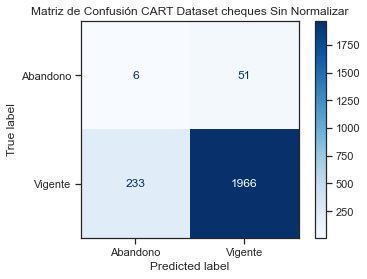

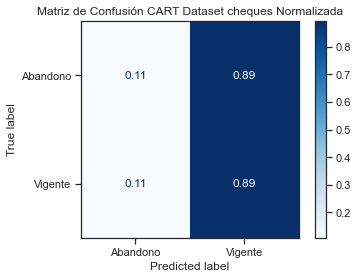

In [28]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión CART Dataset cheques Sin Normalizar", None),
                  ("Matriz de Confusión CART Dataset cheques Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    cart_visualizacion_cm = plot_confusion_matrix(analisis['CART']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    cart_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(cart_visualizacion_cm.confusion_matrix)

pyplot.show()

In [29]:
analisis['CART']['metricas'] = classification_report(Y_validation, analisis['CART']['pred_score'])
print(analisis['CART']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.03      0.11      0.04        57
     Vigente       0.97      0.89      0.93      2199

    accuracy                           0.87      2256
   macro avg       0.50      0.50      0.49      2256
weighted avg       0.95      0.87      0.91      2256



También utilizamos la librería pycm para obtener estadísticas más precisas de nuestro modelo predictivo como ser TPR y FPR

In [30]:
analisis['CART']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['CART']['pred_score'])
print(analisis['CART']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       6              51             

Vigente        233            1966           





Overall Statistics : 

95% CI                                                            (0.86042,0.8878)
ACC Macro                                                         0.87411
ARI                                                               -0.00027
AUNP                                                              0.49965
AUNU                                                              0.49965
Bangdiwala B                                                      0.86878
Bennett S                                                         0.74823
CBA                                                               0.45957
CSI                                                               -0.00044
Chi-Squared                                                       0.00028
Chi-Squared DF                                                    1
Conditi

In [31]:
analisis['CART']['predY'] = analisis['CART']['model'].predict_proba(X_validation)
analisis['CART']['fpr'], analisis['CART']['tpr'], analisis['CART']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['CART']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['CART']['fpr'])
#print(analisis['CART']['tpr'])
#print(analisis['CART']['thresh'])
analisis['CART']['auc'] = auc(analisis['CART']['fpr'], analisis['CART']['tpr'])
print("AUC:", analisis['CART']['auc'])

AUC: 0.5219677205747429


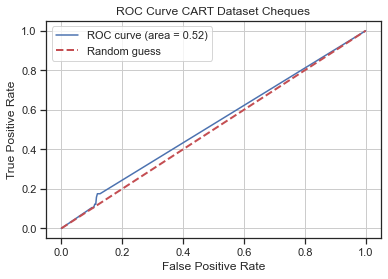

In [32]:
pyplot.plot(analisis['CART']['fpr'], analisis['CART']['tpr'], label='ROC curve (area = %.2f)' %analisis['CART']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve CART Dataset Cheques')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo Random Forest

In [33]:
analisis['RF']['model'] = RandomForestClassifier()
analisis['RF']['model'].fit(X_train_smote, Y_train_smote)
analisis['RF']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

In [34]:
analisis['RF']['pred_score'] = analisis['RF']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['RF']['pred_score']))

0.8856382978723404


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Matriz de Confusión RF Dataset cheques Sin Normalizar
[[   6   51]
 [ 207 1992]]
Matriz de Confusión RF Dataset cheques Normalizada
[[0.10526316 0.89473684]
 [0.0941337  0.9058663 ]]


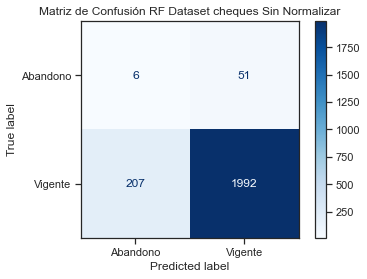

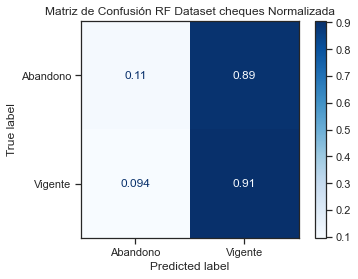

In [35]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión RF Dataset cheques Sin Normalizar", None),
                  ("Matriz de Confusión RF Dataset cheques Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    rf_visualizacion_cm = plot_confusion_matrix(analisis['RF']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    rf_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(rf_visualizacion_cm.confusion_matrix)

pyplot.show()

In [36]:
analisis['RF']['metricas'] = classification_report(Y_validation, analisis['RF']['pred_score'])
print(analisis['RF']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.03      0.11      0.04        57
     Vigente       0.98      0.91      0.94      2199

    accuracy                           0.89      2256
   macro avg       0.50      0.51      0.49      2256
weighted avg       0.95      0.89      0.92      2256



In [37]:
analisis['RF']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['RF']['pred_score'])
print(analisis['RF']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       6              51             

Vigente        207            1992           





Overall Statistics : 

95% CI                                                            (0.87251,0.89877)
ACC Macro                                                         0.88564
ARI                                                               0.00412
AUNP                                                              0.50556
AUNU                                                              0.50556
Bangdiwala B                                                      0.88088
Bennett S                                                         0.77128
CBA                                                               0.46702
CSI                                                               0.00717
Chi-Squared                                                       0.08049
Chi-Squared DF                                                    1
Conditio

In [38]:
analisis['RF']['predY'] = analisis['RF']['model'].predict_proba(X_validation)
analisis['RF']['fpr'], analisis['RF']['tpr'], analisis['RF']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['RF']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['CART']['fpr'])
#print(analisis['CART']['tpr'])
#print(analisis['CART']['thresh'])
analisis['RF']['auc'] = auc(analisis['RF']['fpr'], analisis['RF']['tpr'])
print("AUC:", analisis['RF']['auc'])

AUC: 0.5714918264282809


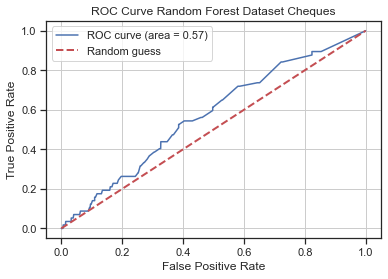

In [39]:
pyplot.plot(analisis['RF']['fpr'], analisis['RF']['tpr'], label='ROC curve (area = %.2f)' %analisis['RF']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve Random Forest Dataset Cheques')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo KNeighbors

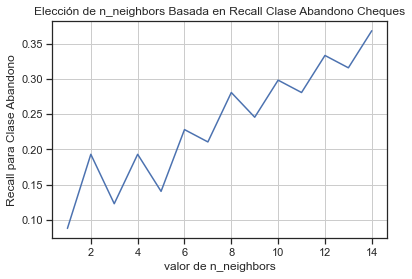

In [40]:
range_k = range(1,15)
kn_scores = {}
kn_scores_list = []
for k in range_k:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train_smote, Y_train_smote)
    kn_y_pred = classifier.predict(X_validation)
    kn_scores[k] = accuracy_score(Y_validation,kn_y_pred)
    kn_scores_list.append(recall_score(Y_validation, kn_y_pred, pos_label = 'Abandono'))

pyplot.plot(range_k,kn_scores_list)
pyplot.title('Elección de n_neighbors Basada en Recall Clase Abandono Cheques')
pyplot.xlabel("valor de n_neighbors")
pyplot.ylabel("Recall para Clase Abandono")
pyplot.grid()
pyplot.show()

In [41]:
analisis['KN']['model'] = KNeighborsClassifier(n_neighbors=14)
analisis['KN']['model'].fit(X_train_smote, Y_train_smote)
analisis['KN']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

In [42]:
analisis['KN']['pred_score'] = analisis['KN']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['KN']['pred_score']))

0.7340425531914894


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Matriz de Confusión KNeighbors Dataset cheques Sin Normalizar
[[  21   36]
 [ 564 1635]]


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Matriz de Confusión KNeighbors Dataset cheques Normalizada
[[0.36842105 0.63157895]
 [0.25648022 0.74351978]]


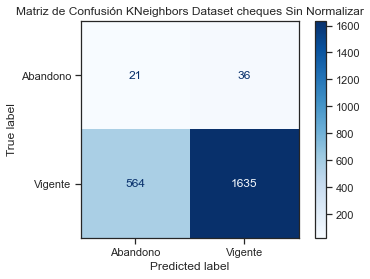

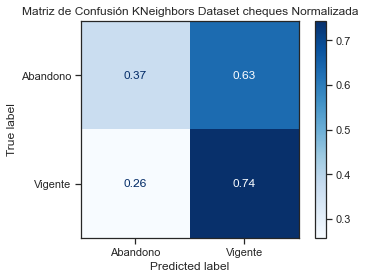

In [43]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión KNeighbors Dataset cheques Sin Normalizar", None),
                  ("Matriz de Confusión KNeighbors Dataset cheques Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    kn_visualizacion_cm = plot_confusion_matrix(analisis['KN']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    kn_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(kn_visualizacion_cm.confusion_matrix)

pyplot.show()

In [44]:
analisis['KN']['metricas'] = classification_report(Y_validation, analisis['KN']['pred_score'])
print(analisis['KN']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.04      0.37      0.07        57
     Vigente       0.98      0.74      0.84      2199

    accuracy                           0.73      2256
   macro avg       0.51      0.56      0.46      2256
weighted avg       0.95      0.73      0.83      2256



In [45]:
analisis['KN']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['KN']['pred_score'])
print(analisis['KN']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       21             36             

Vigente        564            1635           





Overall Statistics : 

95% CI                                                            (0.71581,0.75228)
ACC Macro                                                         0.73404
ARI                                                               0.01285
AUNP                                                              0.55597
AUNU                                                              0.55597
Bangdiwala B                                                      0.72108
Bennett S                                                         0.46809
CBA                                                               0.38971
CSI                                                               0.06315
Chi-Squared                                                       3.6248
Chi-Squared DF                                                    1
Condition

In [46]:
analisis['KN']['predY'] = analisis['KN']['model'].predict_proba(X_validation)
analisis['KN']['fpr'], analisis['KN']['tpr'], analisis['KN']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['KN']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['KN']['fpr'])
#print(analisis['KN']['tpr'])
#print(analisis['KN']['thresh'])
analisis['KN']['auc'] = auc(analisis['KN']['fpr'], analisis['KN']['tpr'])
print("AUC:", analisis['KN']['auc'])

AUC: 0.5735940579051084


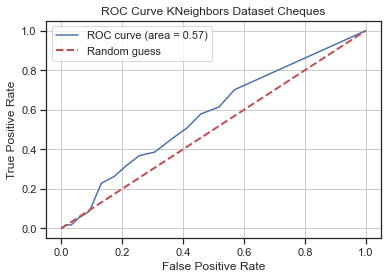

In [47]:
pyplot.plot(analisis['KN']['fpr'], analisis['KN']['tpr'], label='ROC curve (area = %.2f)' %analisis['KN']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve KNeighbors Dataset Cheques')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo Logistic Regression

In [1]:
solver = ['liblinear', 'saga', 'sag', 'newton-cg']
lr_scores = {}
lr_scores_list = []
for k in solver:
    classifier = LogisticRegression(random_state=0, solver=k)
    classifier.fit(X_train_smote, Y_train_smote)
    lr_y_pred = classifier.predict(X_validation)
    lr_scores[k] = accuracy_score(Y_validation,lr_y_pred)
    lr_scores_list.append(recall_score(Y_validation, lr_y_pred, pos_label = 'Abandono'))

pyplot.plot(solver,lr_scores_list)
pyplot.title('Elección del algoritmo de optimización Basada en Recall Clase Abandono Cheques')
pyplot.xlabel("Valor de solver")
pyplot.ylabel("Recall para Clase Abandono")
pyplot.grid()
pyplot.show()

NameError: name 'LogisticRegression' is not defined

In [49]:
analisis['LReg']['model'] = LogisticRegression(random_state=0, solver="sag")
analisis['LReg']['model'].fit(X_train_smote, Y_train_smote)
analisis['LReg']['model'].classes_

C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array(['Abandono', 'Vigente'], dtype=object)

In [50]:
analisis['LReg']['pred_score'] = analisis['LReg']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['LReg']['pred_score']))

0.598404255319149


Matriz de Confusión LReg Dataset cheques Sin Normalizar
[[  35   22]
 [ 884 1315]]
Matriz de Confusión LReg Dataset cheques Normalizada
[[0.61403509 0.38596491]
 [0.40200091 0.59799909]]


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


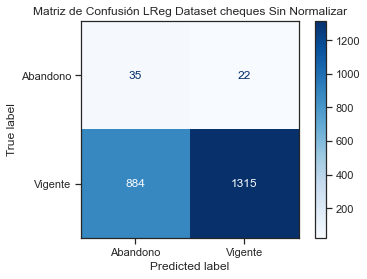

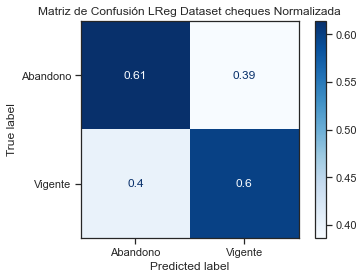

In [51]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión LReg Dataset cheques Sin Normalizar", None),
                  ("Matriz de Confusión LReg Dataset cheques Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    lr_visualizacion_cm = plot_confusion_matrix(analisis['LReg']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    lr_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(lr_visualizacion_cm.confusion_matrix)

pyplot.show()

In [52]:
analisis['LReg']['metricas'] = classification_report(Y_validation, analisis['LReg']['pred_score'])
print(analisis['LReg']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.04      0.61      0.07        57
     Vigente       0.98      0.60      0.74      2199

    accuracy                           0.60      2256
   macro avg       0.51      0.61      0.41      2256
weighted avg       0.96      0.60      0.73      2256



In [53]:
analisis['LReg']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['LReg']['pred_score'])
print(analisis['LReg']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       35             22             

Vigente        884            1315           





Overall Statistics : 

95% CI                                                            (0.57818,0.61863)
ACC Macro                                                         0.5984
ARI                                                               0.00799
AUNP                                                              0.60602
AUNU                                                              0.60602
Bangdiwala B                                                      0.57827
Bennett S                                                         0.19681
CBA                                                               0.31804
CSI                                                               0.11683
Chi-Squared                                                       10.34675
Chi-Squared DF                                                    1
Conditio

In [54]:
analisis['LReg']['predY'] = analisis['LReg']['model'].predict_proba(X_validation)
analisis['LReg']['fpr'], analisis['LReg']['tpr'], analisis['LReg']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['LReg']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['LReg']['fpr'])
#print(analisis['LReg']['tpr'])
#print(analisis['LReg']['thresh'])
analisis['LReg']['auc'] = auc(analisis['LReg']['fpr'], analisis['LReg']['tpr'])
print("AUC:", analisis['LReg']['auc'])

AUC: 0.6189097117509554


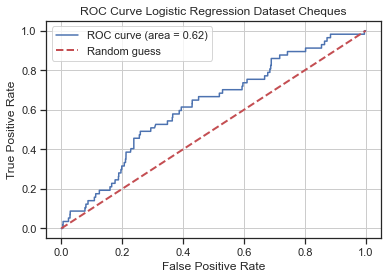

In [55]:
pyplot.plot(analisis['LReg']['fpr'], analisis['LReg']['tpr'], label='ROC curve (area = %.2f)' %analisis['LReg']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve Logistic Regression Dataset Cheques')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()